In [ ]:
from ast import literal_eval
from collections import defaultdict 
from itertools import groupby
from operator import itemgetter 

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from scipy.interpolate import UnivariateSpline

from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.svm import LinearSVC

import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
sns.set()

seed = 42

from sklearn.metrics import (
    average_precision_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix,
    plot_precision_recall_curve, plot_roc_curve, precision_recall_curve, roc_auc_score, roc_curve
)

def plot_confusion_matrix_from_proba(estimator, X, y_true, threshold, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None,
                          cmap='viridis', ax=None):

    y_pred = estimator.predict_proba(X)[:, 1] > threshold
    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = estimator.classes_
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)


def plot_classification_results(clf, X_test, y_test, y_proba=None, threshold=None, nb_disp_thresh=10, harmonic_opt=True):
    fig, ax = plt.subplots(figsize=(15, 4), ncols=3)

    if threshold is None:
        titles_options = [
            ("Confusion matrix", None, ".0f"),  # , without normalization
            # ("Normalized confusion matrix", 'true', ".4f")
        ]
    else:
        titles_options = [
            ("Confusion matrix with threshold {:.4f}".format(threshold), None, ".0f"),  # ,\n without normalization
            # ("Normalized confusion matrix\n with threshold {:.4f}".format(threshold), 'true', ".4f")
        ]

    for ind, (title, normalize, values_format) in enumerate(titles_options):
        if threshold is None:
            plot_confusion_matrix(
                clf, X_test, y_test, display_labels=['0', '1'], cmap=plt.cm.Blues, normalize=normalize,
                values_format=values_format, ax=ax[ind]
            )
        else:
            plot_confusion_matrix_from_proba(
                clf, X_test, y_test, threshold=threshold, display_labels=['0', '1'], cmap=plt.cm.Blues,
                normalize=normalize, values_format=values_format, ax=ax[ind]
            )
        ax[ind].set_title(title)
        ax[ind].grid(False)

    if y_proba is None:
        y_proba = clf.predict_proba(X_test)[:, 1]

    plot_roc_curve(clf, X_test, y_test, ax=ax[1], label="ROC curve")
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    step = len(fpr) // (nb_disp_thresh - 1) if len(fpr) // (nb_disp_thresh - 1) >= 2 else 1

    ax[1].plot(fpr[1:-1:step], tpr[1:-1:step], 'o', label="Thresholds")
    for x, y, txt in zip(fpr[1:-1:step], tpr[1:-1:step], thresholds[1:-1:step]):
        ax[1].annotate(np.round(txt, 2), (x - 0.08, y + 0.02))
    
    if harmonic_opt:
        argmax = np.argmax(2 * tpr * (1 - fpr) / (tpr + (1 - fpr) + 1e-6))
    else:
        argmax = np.argmax(tpr + (1 - fpr))
    ax[1].plot(fpr[argmax], tpr[argmax], 'o', label="Best threshold", color="green")
    ax[1].annotate(np.round(thresholds[argmax], 4), (fpr[argmax] + 0.01, tpr[argmax] - 0.06), color="green")

    ax[1].plot([0, 1], [0, 1], linestyle='--', color='r', label='Chance')
    ax[1].set_title("ROC curve (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
    ax[1].legend()

    plot_precision_recall_curve(clf, X_test, y_test, ax=ax[2], label="PR curve")
    pr, rc, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    step = len(rc) // (nb_disp_thresh - 1) if len(rc) // (nb_disp_thresh - 1) >= 2 else 1
    
    ax[2].plot(
        rc[::step], pr[::step], 'o', label="Thresholds"
    )
    for x, y, txt in zip(rc[1:-1:step], pr[1:-1:step], thresholds[1:-1:step]):
        ax[2].annotate(np.round(txt, 2), (x, y + 0.02))

    if harmonic_opt:
        argmax = np.argmax(2 * pr * rc / (pr + rc + 1e-6))
    else:
        argmax = np.argmax(pr + rc)
    ax[2].plot(rc[argmax], pr[argmax], 'o', label="Best threshold", color="green")
    ax[2].annotate(np.round(thresholds[argmax], 4), (rc[argmax] - 0.18, pr[argmax] - 0.03), color="green")

    ax[2].set_title("PR curve (AP = {:.4f})".format(average_precision_score(y_test, y_proba)))
    ax[2].legend()
    ax[2].set_xlim(-0.05, 1.05)
    ax[2].set_ylim(-0.05, 1.05)

    plt.show()

# Madness at Home and on the Court - Part 2

*Authors: [Emilien Etchevers](https://www.kaggle.com/emimis), [Kieran Janin](https://www.kaggle.com/kieranjanin), [Michael Karpe](https://www.kaggle.com/mika30), [Remi Le Thai](https://www.kaggle.com/remilethai), [Haley Wohlever](https://www.kaggle.com/haleywohlever)*

# Contents

*In the [first notebook](https://www.kaggle.com/emimis/madness-at-home-and-on-the-court-part-1)*

- [Introduction](#Introduction) <br>
- [NCAA March Madness Data Analysis](#NCAAMarchMadnessData)<br>
  * [Seeding and Entertainment](#SeedingandEntertainment)<br>
  * [Madness through Unpredictability](#MadnessthroughUnpredictability)<br>
  * [Entertainment due to Closeness of Games](#EntertainmentduetoClosenessofGames)
    
*In this notebook*

- [Tweets on NCAA Data Analysis](#TweetsonNCAAData)<br>
  * [Temporal Evolution of Engagement](#TemporalEvolutionofEngagement)<br>
  * [Team Mentions Count in Tweets](#TeamMentionsCountinTweets)<br>
  * [Sentiment Analysis for Tweets on NCAA](#SentimentAnalysisforTweetsonNCAA)
- [Conclusion](#Conclusion)


# 3. Tweets on NCAA Data

After thoroughly exploring the NCAA data, we decided to extend our analysis by studying relevant tweets published during the 2015 to 2019 NCAA March Madness tournaments. We built a database of 1.6 million tweets containing the word *NCAA*, using the [GetOldTweets3](https://github.com/Mottl/GetOldTweets3) library. The dataset we built with this library is available [here](https://www.kaggle.com/mika30/ncaa-tweets-20152019) (as well as a processed version [here](https://www.kaggle.com/mika30/ncaa-tweets-processed) to avoid memory issues).

The purpose of this second part of our analysis is to identify trends in tweets published during and related to the competition. As discussed in Part 1, we want to distinguish an *objective* madness, explainable by match and player data, from a *subjective* madness that can be observed in the public sentiment surrounding the games.


## 3.1. Temporal Evolution of Engagement

We first study *engagement* on Twitter. *Engagement* on Twitter is defined by three types of actions: retweets, replies, and favorites (or likes). We plot the evolution of the number of each of these actions over the 21 days of the competition for each season, as well as the evolution of the number of tweets.

While we can see that the number of tweets including the word *NCAA* tends to slightly decrease over the years (or at least remains constant), we can observe an increase in the number of retweets and replies over the years. We also note an even higher increase in the number of favorites, this latest observation showing that people tend to express themselves more and more using the favorites feature on Twitter.

In [ ]:
processing = False

if processing:
    tweets = pd.read_csv('/kaggle/input/ncaa-tweets-20152019/ncaa-tweets-2015-2019.csv', parse_dates=["date"])
    tweets["date"] = tweets["date"] - pd.Timedelta(hours=4)  # UTC to ET
    tweets = tweets[tweets["date"].apply(
        lambda x: str(x)[:10] not in ["2015-03-16", "2016-03-14", "2017-03-13", "2018-03-12", "2019-03-18"]
    )]
else:
    tweets = pd.read_csv(
        '/kaggle/input/ncaa-tweets-processed/tweets-processed.csv', parse_dates=["date"],
        converters={"TeamIDMatch": literal_eval, "GameandTeamMatch": literal_eval}
    )

display(tweets.sample(5))

gbcount = tweets.groupby([tweets['date'].dt.date]).count()
gbsumday = tweets.groupby([tweets['date'].dt.date])["replies", "retweets", "favorites"].sum()

colors = ['r', 'g', 'b', 'purple', 'orange']

begin_year, end_year = 2015, 2019
begin_day, end_day = 1, 21
# begin_day, end_day = 134, 154
nb_days = end_day - begin_day + 1

fig, ax = plt.subplots(figsize=(15, 8), nrows=2, ncols=2)
for axis, engagement in enumerate(["tweets", "replies", "retweets", "favorites"]):
    for ind, year in enumerate(range(begin_year, end_year + 1)):
        if engagement == "tweets":
            ax[axis // 2, axis % 2].plot(
                range(1, nb_days + 1), gbcount["date"][nb_days * ind:nb_days * (ind + 1)],c=colors[ind], label=year
            )
        else:
            ax[axis // 2, axis % 2].plot(
                range(1, nb_days + 1), gbsumday[engagement][nb_days * ind:nb_days * (ind + 1)], c=colors[ind], label=year
            )
    ax[axis // 2, axis % 2].set_xticks(range(1, nb_days + 1))
    ax[axis // 2, axis % 2].set_xlabel("Day of the competition")
    ax[axis // 2, axis % 2].set_ylabel("Number of " + engagement)
    # ax[axis // 2, axis % 2].set_title("Number of " + engagement)
    ax[axis // 2, axis % 2].legend(loc="upper center")

plt.show()

If we consider the number of favorites as a key indicator of the madness generated by the competition, we can remark that the major spikes in favorites reflect the March Madness schedule. Spikes at the beginning of the competition correspond to *First Round* and *Second Round*, spikes in the middle to *Sweet Sixteen* and *Elite Eight*, and in the end to the *Final Four*.

The lack of spikes when there are no games shows that madness is generated by the games themselves. Moreover, the much higher number of favorites compared to the number of tweets, replies, and retweets indicates that NCAA March Madness creates positive reactions. If there were more negative comments in reaction to games, it is likely people would feel the need to reply to either also express their frustration or to argue back against someone rather than simply favorite the initial tweet.


## 3.2. Team Mentions Count in Tweets

In this section, we aim to refine our study by focusing on the number of team mentions per team and per day. Using tables of team spellings, player names, and coach names, we tried to find tweets mentioning specific teams or people. We present these results in the form of heatmaps, the rows corresponding to teams and the columns to the day of the competition.

In [ ]:
# stop_words = stopwords.words("english")
# stemmer = SnowballStemmer('english')

def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+", "", tweet)  # remove hyperlinks
    tweet = re.sub(r"@\S+", "", tweet)  # remove user names after @
    tweet = re.sub(r"&\w+;", "", tweet)  # remove first words after & (HTML chars)
    tweet = re.sub(r"\n", " ", tweet)  # remove newlines
    # tweet = re.sub(r"[^\w\s]", "", tweet)  # remove special characters
    tweet = re.sub(r"[^A-Za-z0-9?,.;/:!\)\(\-\s]+", " ", tweet)  # keep letters, numbers, spaces and some punctuation
    tweet = re.sub(r"([\w\s-]+|[^\w\s-]+)\s*", r"\1 ", tweet)  # separate words from punctuation except for -
    tweet = re.sub(r" +", " ", tweet)  # remove multiple whitespaces
    tweet = re.sub(r"^\s+|\s+$", "", tweet)  # remove leading and trailing spaces
    # tweet = " ".join([word for word in tweet.split() if word not in stop_words])  # remove stop words
    # tweet = " ".join([stemmer.stem(word) for word in tweet.split()])  # stemming
    return tweet


if processing:
    tweets["processed_text"] = tweets["text"].apply(clean_tweet)
    tweets = tweets[tweets["processed_text"] != ""].drop_duplicates(["processed_text"]).reset_index(drop=True)
    tweets["Season"] = pd.to_datetime(tweets["date"]).dt.year


PATH_TO_MEN_DATA = "../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data"
PATH_TO_STAGE2_DATA = "../input/march-madness-analytics-2020/MDataFiles_Stage2"

team_spellings = pd.read_csv(PATH_TO_STAGE2_DATA + "/MTeamSpellings.csv", encoding='latin1')
team_players = pd.read_csv(PATH_TO_MEN_DATA + "/MPlayers.csv")
team_coaches = pd.read_csv(PATH_TO_STAGE2_DATA + "/MTeamCoaches.csv")

team_id_to_spellings = team_spellings.groupby('TeamID')['TeamNameSpelling'].apply(lambda x: list(set(x))).to_dict()
team_id_to_players = team_players.groupby('TeamID')['LastName'].apply(lambda x: list(set(x))).to_dict()
team_id_to_coaches = team_coaches.groupby('TeamID')['CoachName'].apply(lambda x: list(set(x))).to_dict()

team_id_to_tweet_mentions = {
    key: sorted(list(
        possible_name.lower() for possible_name in set(
            value + team_id_to_players.get(key, []) + team_id_to_coaches.get(key, [])
        ) if len(possible_name) >= 4
    )) for key, value in team_id_to_spellings.items()
}

MEvents = pd.concat([
    pd.read_csv(PATH_TO_MEN_DATA + "/MEvents{}.csv".format(year)) for year in range(begin_year, end_year + 1)
])
MSeasons = pd.read_csv(PATH_TO_STAGE2_DATA + "/MSeasons.csv")
MNCAATourneySeeds = pd.read_csv(PATH_TO_STAGE2_DATA + "/MNCAATourneySeeds.csv")
MNCAATourneyCompactResults = pd.read_csv(PATH_TO_STAGE2_DATA + "/MNCAATourneyCompactResults.csv")

# Dictionary with all teams from 2015 to 2019  
year_to_team_ids = {
    year: MNCAATourneySeeds[MNCAATourneySeeds["Season"] == year]["TeamID"].tolist()
    for year in range(begin_year, end_year + 1)
}  # NCAATeamsDict

# Dictionary with the starting date of a given season
year_to_begin_day = {
    key: pd.to_datetime(value) for key, value in {
        2015: "2015-03-17", 2016: "2016-03-15", 2017: "2017-03-14", 2018: "2018-03-13", 2019: "2019-03-19"
    }.items()
}

# Dictionary with the individual Tourney games with day number, winning team ID and losing team ID
year_to_day_to_game_ids = {
    year : [
        (DayNum,WTeamID,LTeamID) 
        for DayNum,WTeamID,LTeamID in zip(
            MNCAATourneyCompactResults[MNCAATourneyCompactResults["Season"] == year]["DayNum"] - 133,
            MNCAATourneyCompactResults[MNCAATourneyCompactResults["Season"] == year]["WTeamID"],
            MNCAATourneyCompactResults[MNCAATourneyCompactResults["Season"] == year]["LTeamID"]
        )
    ] for year in range(begin_year, end_year + 1)
}

# Create embedded dictionnary for each tournement day
for year in range(begin_year, end_year + 1):
    year_to_day_to_game_ids[year] = dict(
        (DayNum, [team for Teams in itr for team in Teams[1:]])
        for DayNum, itr in groupby(year_to_day_to_game_ids[year], itemgetter(0))
    ) 


if processing:
    # Setting up DayNum column  
    tweets["DayNum"] = tweets["date"].apply(lambda x: x - year_to_begin_day[int(x.year)]).dt.days + 1

    for year in range(begin_year, end_year + 1):
        tweets.loc[tweets["Season"] == year, "TeamIDMatch"] = tweets.loc[tweets["Season"] == year, "text"].apply(
            lambda tweet: [
                key for key in year_to_team_ids[year]
                if any(keyword in tweet for keyword in team_id_to_tweet_mentions[key])
            ]
        )
        tweets.loc[tweets["Season"] == year, "GameandTeamMatch"] = tweets.loc[
            tweets["Season"] == year, ["TeamIDMatch", "Season", "DayNum"]
        ].apply(
            lambda values: list(set(values[0]) & set(year_to_day_to_game_ids[values[1]].get(values[2], []))), axis=1
        )

    tweets.to_csv("tweets-processed.csv", index=False)


def plot_team_day_heatmap(year_to_matrix, title):
    fig, ax = plt.subplots(figsize=(14, 15))
    sns.heatmap(
        year_to_matrix[end_year], cmap=plt.cm.Blues, ax=ax, xticklabels=range(1, nb_days + 1),
        yticklabels=[team_id_to_spellings[x][0] for x in year_to_team_ids[end_year]],  # cbar=False
    )
    ax.set_title("{} in Year {}".format(title, end_year))
    ax.set_xlabel("Day of competition (1st to 21st)")
    ax.set_ylabel("Name of the team")
    plt.show()

    nb_rows, nb_cols = 2, 3
    fig, ax = plt.subplots(figsize=(15, 10), nrows=nb_rows, ncols=nb_cols)
    for ind, year in enumerate(range(begin_year, end_year + 1)):
        sns.heatmap(
            year_to_matrix[year], cmap=plt.cm.Blues, ax=ax[ind // nb_cols, ind % nb_cols],
            xticklabels=False, yticklabels=False,  # cbar=False
        )
        ax[ind // nb_cols, ind % nb_cols].set_title("{} in Year {}".format(title, year))
        ax[ind // nb_cols, ind % nb_cols].set_xlabel("Day of competition (1st to 21st)")
        ax[ind // nb_cols, ind % nb_cols].set_ylabel("ID of the team")
    plt.show()


year_to_team_mentions_count = {
    year: np.array([[
        tweets[
            (tweets["Season"] == year) & (tweets["DayNum"] == day)
        ]["TeamIDMatch"].apply(lambda x: team_id in x).sum()
        for day in range(begin_day, end_day + 1)
    ] for team_id in year_to_team_ids[year]
    ]) for year in range(begin_year, end_year + 1)
}

plot_team_day_heatmap(year_to_team_mentions_count, "Number of mentions")

Again, we note for all years that the darkest columns, i.e. the ones with the highest number of mentions in a given day, correspond to the main stages of the tournament. When looking at the rows, we can observe that some teams are mentioned more than others in our set of tweets.

For example, on the heatmap corresponding to the year 2019, we observe that the team that generated the highest number of mentions on a given day is *Northern Kentucky* on Day 4. When looking at the 2019 schedule as well as press releases, we can confirm that *Northern Kentucky* was playing on 03/22/19. They lost a game against *Texas Tech*, who is known for their solid defense:

|                         |                         |
|-------------------------|-------------------------|
| 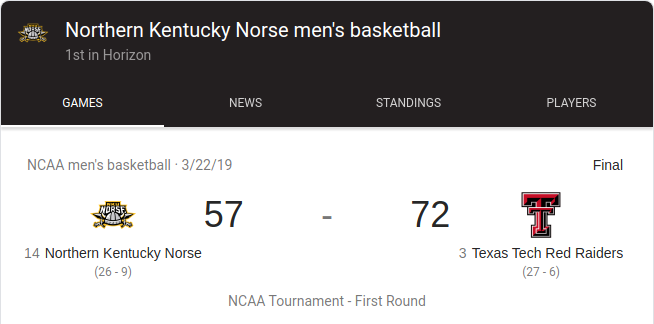 | 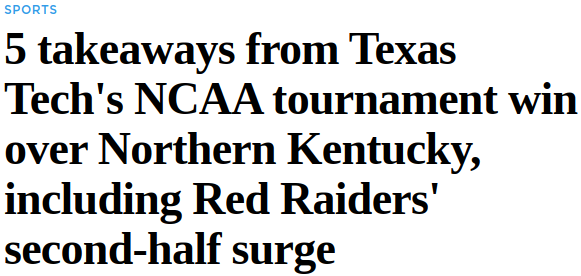 |

<br>

This new indicator of team mentions on a given day shows that some of the teams likely have more supporters active on Twitter! The number of active supporters on Twitter may then be an indicator for the madness generated by a team.


## 3.3. Sentiment Analysis for Tweets on NCAA

In this final section of our madness exploration, we applied sentiment analysis to the NCAA Tweets, training a classifier on the [Sentiment140](https://www.kaggle.com/kazanova/sentiment140) dataset (which also contains around 1.6 million tweets) and then predicting sentiments on NCAA tweets.

We display a sample of lines of Sentiment140 dataset, as well as the performance of our classifier on a validation set (with an accuracy around 82.5% and an area under the ROC curve around 0.906) taken from the Sentiment140 dataset. We also display the probability distribution of positive and negative sentiments for the validation set and NCAA tweets.

In [ ]:
if processing:
    sentiment140 = pd.read_csv(
        '/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', header=None, parse_dates=[2],
        names=["sentiment", "id", "date", "flag", "username", "text"], encoding="ISO-8859-1"
    )
    sentiment140["processed_text"] = sentiment140["text"].apply(clean_tweet)
    sentiment140 = sentiment140[sentiment140["processed_text"] != ""].drop_duplicates(["processed_text"]).reset_index(drop=True)
    sentiment140["sentiment"] = sentiment140["sentiment"].apply(lambda x: x // 4)
    sentiment140.to_csv("sentiment140-processed.csv", encoding="utf-8", index=False)
else:
    sentiment140 = pd.read_csv('/kaggle/input/ncaa-tweets-processed/sentiment140-processed.csv')

display(sentiment140.sample(5))

X_train, X_val, y_train, y_val = train_test_split(
    sentiment140["processed_text"].apply(str), sentiment140["sentiment"], random_state=seed, test_size=0.2
)
X_test = tweets["processed_text"].apply(str)

pipe = make_pipeline(
    FeatureUnion([
        ('words', TfidfVectorizer(ngram_range=(1, 3), analyzer='word')),
        ('chars', TfidfVectorizer(ngram_range=(1, 3), analyzer='char')),
    ]),
    CalibratedClassifierCV(LinearSVC(C=1.0, random_state=seed), cv=5),
)
pipe.fit(X_train, y_train)

y_val_proba = pipe.predict_proba(X_val)[:, 1]
threshold = 0.4874
y_val_pred = y_val_proba > threshold

plot_classification_results(pipe, X_val, y_val, y_proba=y_val_proba, threshold=threshold)
plt.show()

plt.figure(figsize=(15, 4))
plt.hist(y_val_proba, bins=100, density=True, label="Sentiment140 Tweets")

y_proba_1 = pipe.predict_proba(X_test[:len(X_test) // 2])[:, 1]
y_proba_2 = pipe.predict_proba(X_test[len(X_test) // 2:])[:, 1]
y_proba = np.concatenate([y_proba_1, y_proba_2])
y_pred = (y_proba > threshold) * 1

plt.hist(y_proba, bins=100, density=True, label="NCAA Tweets", alpha=0.5)
plt.title("Probability density of positive sentiments")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

tweets["proba"] = y_proba
tweets["prediction"] = y_pred
tweets.to_csv("tweets-sentiments.csv", index=False)

While the classifier is able to make a clear distinction between positive and negative tweets on the Sentiment140 dataset, predictions on our NCAA tweets show a more uniform distribution that is skewed left. The fact that the probability distribution on NCAA tweets tends to be more uniform is due to the neutrality of a sizeable proportion of NCAA tweets. However, the skewed-left-characteristic shows that NCAA generates more positive sentiments than negative sentiments overall. This shows that what we call *madness* in the NCAA competition is more related to positive than negative sentiments.

With the predictions from our classifier, we display below heatmaps corresponding the average sentiment (between 0 and 1) for a given team on a given day. Here, 0 is taken as a negative sentiment, 1 is taken as a positive sentiment, and 0.5 is taken as the threshold between a positive and negative sentiment.

In [ ]:
year_to_average_sentiment = {
    year: np.array([[
        tweets[
            (tweets["Season"] == year) & (tweets["DayNum"] == day) &
            (tweets["TeamIDMatch"].apply(lambda x: team_id in x))
        ].proba.mean()
        for day in range(begin_day, end_day + 1)
    ] for team_id in year_to_team_ids[year]
    ]) for year in range(begin_year, end_year + 1)
}

plot_team_day_heatmap(year_to_average_sentiment, "Average sentiment")

Although we do not observe clear distinctions between teams for a positive or a negative sentiment, we see that the average sentiment for a given team on a given day is over 0.5. meaning that overall positive sentiments are more prevalent than negative ones. This follows our previous observation that NCAA March Madness creates positive reactions in its fans.


# 4. Conclusion

Our exploration of the NCAA data in Part 1 revealed that there does indeed exist a link between watching higher seeded teams compete and the objective entertainment of those games. Filled with more point-effective shots, a greater degree of player collaboration, and higher scores, we are able to conclude that the madness of a game is correlated to the ranks of the involved teams.

Similarly, we were able to see trends related to the madness of a match and the closeness of the score throughout. While we feel that the madness cannot truly be predicted from these metrics alone, it in many ways confirms our initial suspicions that much of the delightful madness of this tournament is derived from its inability to be predicted.

The sentiment analysis we have completed here in Part 2 is telling of the enjoyment of fans. In some ways it may seem that our analysis of Twitter data was unable to uncover any specific and telling trends related to the public’s response to March Madness throughout the season. We see that their social media activity is centered on the main parts of the competition and that the most buzz is generated right at the start when the most teams are involved, and the highest number of games occur. While all of this is relatively intuitive, what is somewhat surprising and worthy of further evaluation is that the overall reaction to these games is positive.

Twitter has in many ways built up a reputation for being a place that people can express short, inflammatory remarks which may be expected when upsets inevitably occur throughout the tournament. However, this is not the trend we saw. As indicated by the trends in positive sentiments expressed on Twitter, even when upsets occur and favorites lose, by and large the some 40 million people following the competition still love the game and we are sure that, after the cancellation of this season, there will be even more people looking forward to watching the madness play out in the 2021 games.